Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

Importing the dataset

In [2]:
df = pd.read_csv("/content/stroke-data (1).csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


Checking the structure of the data and presence of any null values

In [5]:
df.shape

(5110, 12)

In [6]:
df.size

61320

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


### Check for any outliers.

In [9]:
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


### Check for any outliers present in my independent variables.

In [10]:
import plotly.express as px
import pandas as pd

# Assuming df is your DataFrame and you want to plot boxplots for the numerical columns

# Select only numerical columns from the dataframe
numerical_df = df.select_dtypes(include=['number'])  # This will include int and float columns

# Get the number of numerical features
num_features = len(numerical_df.columns)

# Create a list of figures for each numerical feature
figures = []

# Plot a boxplot for each numerical feature
for column in numerical_df.columns:
    fig = px.box(numerical_df, y=column, title=f"Boxplot for {column}")
    figures.append(fig)

# Show the boxplots
for fig in figures:
    fig.show()


Treating the null values

In [11]:
# Select only numeric columns (excluding 'stroke')
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('stroke')  # Remove 'stroke' from the list

# Drop 'stroke' column from df
df_without_stroke = df.drop('stroke', axis=1)

# Loop through each numeric column to calculate outliers and percentage of outliers
for column in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_without_stroke[column].quantile(0.01)
    Q3 = df_without_stroke[column].quantile(0.90)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df_without_stroke[(df_without_stroke[column] < lower_bound) | (df_without_stroke[column] > upper_bound)]

    # Calculate the percentage of outliers
    num_outliers = outliers.shape[0]  # number of outliers
    total_data_points = df_without_stroke[column].shape[0]  # total data points in the column
    outlier_percentage = (num_outliers / total_data_points) * 100

    # Print the results
    print(f"Outliers detected in column '{column}':")
    print(outliers)
    print(f"Percentage of outliers in '{column}': {outlier_percentage:.2f}%\n")

Outliers detected in column 'id':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'id': 0.00%

Outliers detected in column 'age':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'age': 0.00%

Outliers detected in column 'hypertension':
         id  gender   age  hypertension  heart_disease ever_married  \
4      1665  Female  79.0             1              0          Yes   
6     53882    Male  74.0             1              1          Yes   
10    12109  Female  81.0             1              0          Yes   
15    58202  Female  50.0             1              0          Yes   
17    34120    Male  75.0             1              0          Yes   
...     ...     ...   ...           ...            ...  

## Fill the outliers

In [12]:
median_value = df[numeric_cols].median()
median_value

,0
id,36932.000
age,45.000
hypertension,0.000
heart_disease,0.000
avg_glucose_level,91.885
bmi,28.100


In [13]:
from sklearn.impute import KNNImputer

# Create KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Replace outliers using KNN
for column in numeric_cols:
    Q1 = df[column].quantile(0.01)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Apply KNN imputation to replace outliers
    df[column] = df[column].mask(outlier_mask)
    df[column] = knn_imputer.fit_transform(df[[column]])

    print(f"Outliers in column '{column}' replaced with KNN imputation.")

Outliers in column 'id' replaced with KNN imputation.
Outliers in column 'age' replaced with KNN imputation.
Outliers in column 'hypertension' replaced with KNN imputation.
Outliers in column 'heart_disease' replaced with KNN imputation.
Outliers in column 'avg_glucose_level' replaced with KNN imputation.
Outliers in column 'bmi' replaced with KNN imputation.


In [14]:
# Select only numeric columns (excluding 'stroke')
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('stroke')  # Remove 'stroke' from the list

# Drop 'stroke' column from df
df_without_stroke = df.drop('stroke', axis=1)

# Loop through each numeric column to calculate outliers and percentage of outliers
for column in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_without_stroke[column].quantile(0.01)
    Q3 = df_without_stroke[column].quantile(0.90)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df_without_stroke[(df_without_stroke[column] < lower_bound) | (df_without_stroke[column] > upper_bound)]

    # Calculate the percentage of outliers
    num_outliers = outliers.shape[0]  # number of outliers
    total_data_points = df_without_stroke[column].shape[0]  # total data points in the column
    outlier_percentage = (num_outliers / total_data_points) * 100

    # Print the results
    print(f"Outliers detected in column '{column}':")
    print(outliers)
    print(f"Percentage of outliers in '{column}': {outlier_percentage:.2f}%\n")

Outliers detected in column 'id':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'id': 0.00%

Outliers detected in column 'age':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'age': 0.00%

Outliers detected in column 'hypertension':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'hypertension': 0.00%

Outliers detected in column 'heart_disease':
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []
Percentage of outliers in 'heart_disease': 0.00%

Outliers det

In [15]:
df['bmi'].value_counts()

,count
bmi,
28.85636,204
28.70000,41
28.40000,38
27.70000,37
26.70000,37
...,...
54.30000,1
47.90000,1
13.00000,1


In [16]:
df['bmi'].mean()

np.float64(28.85635955972279)

In [17]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

<ipython-input-17-2a6d4795ba2f>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [18]:
df['bmi'].isnull().sum()

np.int64(0)

In [19]:
type('bmi')

str

In [20]:
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   float64
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   float64
 4   heart_disease      5110 non-null   float64
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 479.2+ KB


1. Gender

In [22]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [23]:
df['gender'].value_counts()

,count
gender,
Female,2994
Male,2115
Other,1


As there is only 1 value present for the OTHER, we will drop that

In [24]:
df = df.drop(df[df['gender'] == 'Other'].index)

In [25]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,0.0,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,28.85636,never smoked,1
2,31112.0,Male,80.0,0.0,0.0,Yes,Private,Rural,105.92,32.50000,never smoked,1
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.23,34.40000,smokes,1
4,1665.0,Female,79.0,0.0,0.0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1


In [26]:
df['gender'].value_counts()

,count
gender,
Female,2994
Male,2115


Now replacing the Male as 1 and Female as 0

In [27]:
df['gender'].replace({'Male': 1, 'Female': 0}, inplace = True)

<ipython-input-27-a05e76498d29>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-27-a05e76498d29>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [28]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,1,67.0,0.0,0.0,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676.0,0,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,28.85636,never smoked,1
2,31112.0,1,80.0,0.0,0.0,Yes,Private,Rural,105.92,32.50000,never smoked,1


2. Ever_married

In [29]:
df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [30]:
df['ever_married'].value_counts()

,count
ever_married,
Yes,3353
No,1756


Replacing Yes as 1 and No and 0

In [31]:
df['ever_married'].replace({'Yes' : 1, 'No' : 0}, inplace = True)

<ipython-input-31-8391b8ec88f2>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-31-8391b8ec88f2>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [32]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,1,67.0,0.0,0.0,1,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676.0,0,61.0,0.0,0.0,1,Self-employed,Rural,202.21,28.85636,never smoked,1
2,31112.0,1,80.0,0.0,0.0,1,Private,Rural,105.92,32.50000,never smoked,1


3. Work Type

In [33]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [34]:
df['work_type'].value_counts()

,count
work_type,
Private,2924
Self-employed,819
children,687
Govt_job,657
Never_worked,22


4. Residence type

In [35]:
df['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [36]:
df['Residence_type'].value_counts()

,count
Residence_type,
Urban,2596
Rural,2513


In [37]:
df['Residence_type'].replace({'Urban' : 1, 'Rural' : 0}, inplace = True)

<ipython-input-37-fadd75f3552d>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-37-fadd75f3552d>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [38]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,1,67.0,0.0,0.0,1,Private,1,228.69,36.60000,formerly smoked,1
1,51676.0,0,61.0,0.0,0.0,1,Self-employed,0,202.21,28.85636,never smoked,1
2,31112.0,1,80.0,0.0,0.0,1,Private,0,105.92,32.50000,never smoked,1


5. Smoking status

In [39]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [40]:
df['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,884
smokes,789


6. ID

I will drop this feature as it has no impact on my target feature.

In [41]:
df.drop('id', axis = 1, inplace = True)

In [42]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,0.0,1,Private,1,228.69,36.60000,formerly smoked,1
1,0,61.0,0.0,0.0,1,Self-employed,0,202.21,28.85636,never smoked,1
2,1,80.0,0.0,0.0,1,Private,0,105.92,32.50000,never smoked,1


In [43]:
df.dtypes

,0
gender,int64
age,float64
hypertension,float64
heart_disease,float64
ever_married,int64
work_type,object
Residence_type,int64
avg_glucose_level,float64
bmi,float64
smoking_status,object


Target Column (Stroke)
Our target column consist of 0 and 1 which result to Binary Classification Problem

In [44]:
df['stroke'].value_counts()

,count
stroke,
0,4860
1,249


In [45]:
df['stroke'].value_counts(normalize = True) * 100

,proportion
stroke,
0,95.126248
1,4.873752


The dataset is in imbalance form as the proportion of not having stroke is 95% whreas the proportion of having stroke is only 5%. Hence we need to fix this.

In [46]:
import plotly.express as px
stroke_counts = df['stroke'].value_counts()
fig = px.bar(stroke_counts, x=stroke_counts.index, y=stroke_counts.values,
             labels={'x': 'Stroke Type', 'y': 'Count'},
             title='Stroke Count Distribution')
fig.show()


We will use ROC metric to fix the imbalance traget column dataset.

<Axes: xlabel='age', ylabel='Count'>

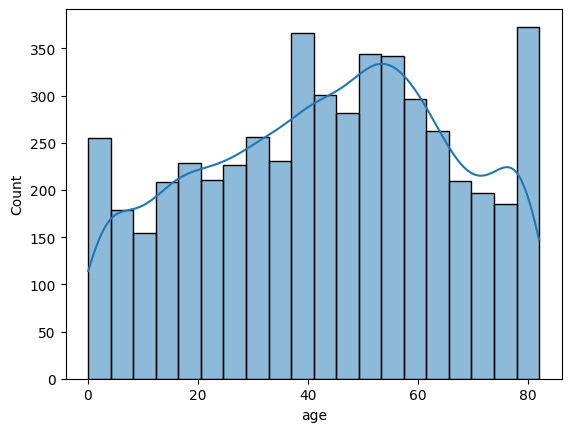

In [47]:
 sns.histplot(x = df['age'], kde = True)

In [48]:
gender_counts = df['gender'].value_counts()

# Create a bar plot using plotly express
fig = px.bar(
    x=gender_counts.index,
    y=gender_counts.values,
    labels={'x': 'Gender', 'y': 'Count'},
    title='Gender Distribution'
)

# Show the plot
fig.show()


Male are having higher chances of getting stroke as compared to female

Dividing the data as per categorical and numerical features

In [49]:
categorical_features = [x for x in df.columns if df[x].dtypes == 'O']

In [50]:
categorical_features

['work_type', 'smoking_status']

In [51]:
numerical_features = [x for x in df.columns if df[x].dtypes != 'O']

In [52]:
numerical_features

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'stroke']

Checking the correlation between the dependent and independent variables

In [53]:
df[numerical_features + ['stroke']].corr()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,stroke
gender,1.000000,-0.027752,NaN,NaN,-0.030171,-0.006105,0.054722,-0.029125,0.009081,0.009081
age,-0.027752,1.000000,NaN,NaN,0.679084,0.014031,0.238323,0.335522,0.245239,0.245239
hypertension,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heart_disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ever_married,-0.030171,0.679084,NaN,NaN,1.000000,0.005988,0.155329,0.344904,0.108299,0.108299
Residence_type,-0.006105,0.014031,NaN,NaN,0.005988,1.000000,-0.004783,0.001920,0.015415,0.015415
avg_glucose_level,0.054722,0.238323,NaN,NaN,0.155329,-0.004783,1.000000,0.176557,0.131991,0.131991
bmi,-0.029125,0.335522,NaN,NaN,0.344904,0.001920,0.176557,1.000000,0.040575,0.040575
stroke,0.009081,0.245239,NaN,NaN,0.108299,0.015415,0.131991,0.040575,1.000000,1.000000
stroke,0.009081,0.245239,NaN,NaN,0.108299,0.015415,0.131991,0.040575,1.000000,1.000000


In [54]:
import plotly.graph_objects as go
correlation_matrix = df[numerical_features + ['stroke']].corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,  # The correlation matrix values
    x=correlation_matrix.columns,  # Column names as x-axis
    y=correlation_matrix.columns,  # Row names as y-axis
    colorscale='Viridis',  # You can choose different color scales
    colorbar=dict(title="Correlation"),  # Title for the color bar
    zmin=-1, zmax=1,  # Set range for color intensity (correlation values between -1 and 1)
))

# Add annotations (correlation coefficients) to each cell
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        fig.add_annotation(
            x=correlation_matrix.columns[j],
            y=correlation_matrix.columns[i],
            text=f"{correlation_matrix.iloc[i, j]:.2f}",
            showarrow=False,
            font=dict(size=10, color="white"),
            align="center"
        )

# Update layout for better presentation
fig.update_layout(
    title="Correlation Heatmap",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=True
)

# Show the plot
fig.show()


<Axes: >

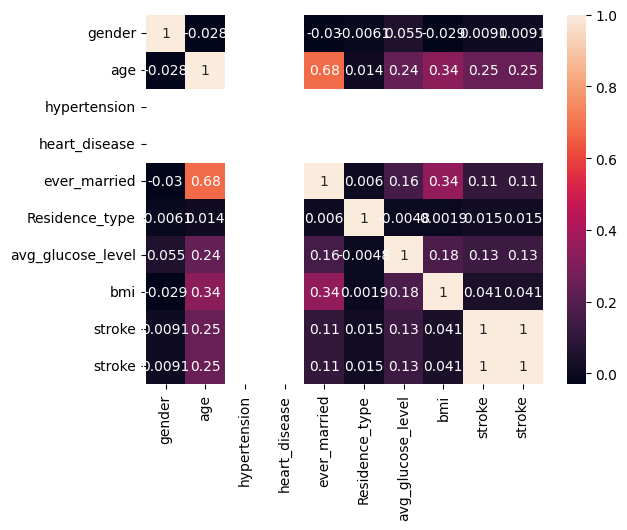

In [55]:
sns.heatmap(df[numerical_features + ['stroke']].corr(), annot = True)

There is no features which are hiving higher correlation with our target column.

In [56]:
numerical_features

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [57]:
categorical_features

['work_type', 'smoking_status']

In [58]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,0.0,1,Private,1,228.69,36.60000,formerly smoked,1
1,0,61.0,0.0,0.0,1,Self-employed,0,202.21,28.85636,never smoked,1
2,1,80.0,0.0,0.0,1,Private,0,105.92,32.50000,never smoked,1


In [59]:
df['bmi'].shape

(5109,)

Converting my categorical columns to numerical columns

In [60]:
categorical_features

['work_type', 'smoking_status']

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   float64
 3   heart_disease      5109 non-null   float64
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 479.0+ KB


In [62]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [63]:
numerical_features

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [64]:
# Drop rows with any null values in the relevant columns
df = df.dropna(subset=['work_type', 'smoking_status'])

# Ensure proper data types
df['work_type'] = df['work_type'].astype(str)
df['smoking_status'] = df['smoking_status'].astype(str)

# Create a OneHotEncoder instance
ohe = OneHotEncoder()

# Fit and transform the categorical columns
encoded_features = ohe.fit_transform(df[['work_type', 'smoking_status']])

# Create a DataFrame with the new encoded features
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out(['work_type', 'smoking_status']))

# Concatenate the original DataFrame with the new one, dropping the original columns
df = pd.concat([df.drop(['work_type', 'smoking_status'], axis=1), encoded_df], axis=1)

print(df)

      gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0        1.0  67.0           0.0            0.0           1.0             1.0   
1        0.0  61.0           0.0            0.0           1.0             0.0   
2        1.0  80.0           0.0            0.0           1.0             0.0   
3        0.0  49.0           0.0            0.0           1.0             1.0   
4        0.0  79.0           0.0            0.0           1.0             0.0   
...      ...   ...           ...            ...           ...             ...   
5106     0.0  81.0           0.0            0.0           1.0             1.0   
5107     0.0  35.0           0.0            0.0           1.0             0.0   
5108     1.0  51.0           0.0            0.0           1.0             0.0   
5109     0.0  44.0           0.0            0.0           1.0             1.0   
3116     NaN   NaN           NaN            NaN           NaN             NaN   

      avg_glucose_level    

In [65]:
df = df.drop(df.index[-2:])

In [66]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
Residence_type,0
avg_glucose_level,0
bmi,0
stroke,0
work_type_Govt_job,0


In [67]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0.0,0.0,1.0,1.0,228.69,36.60000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,61.0,0.0,0.0,1.0,0.0,202.21,28.85636,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,80.0,0.0,0.0,1.0,0.0,105.92,32.50000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<Axes: >

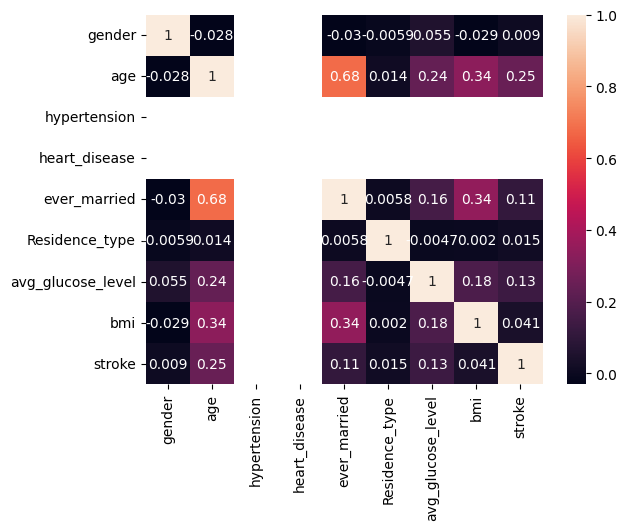

In [68]:
sns.heatmap(df[numerical_features].corr(), annot = True)

There is no correlation hence we can go for model prediction

In [69]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0.0,0.0,1.0,1.0,228.69,36.60000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,61.0,0.0,0.0,1.0,0.0,202.21,28.85636,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


                                  gender       age  hypertension  \
gender                          1.000000 -0.027748           NaN   
age                            -0.027748  1.000000           NaN   
hypertension                         NaN       NaN           NaN   
heart_disease                        NaN       NaN           NaN   
ever_married                   -0.030056  0.679114           NaN   
Residence_type                 -0.005944  0.014025           NaN   
avg_glucose_level               0.054651  0.238331           NaN   
bmi                            -0.029186  0.335529           NaN   
stroke                          0.009044  0.245242           NaN   
work_type_Govt_job             -0.015475  0.064128           NaN   
work_type_Never_worked         -0.006732 -0.059138           NaN   
work_type_Private              -0.017434  0.085076           NaN   
work_type_Self-employed        -0.008787  0.190146           NaN   
work_type_children              0.051239 -0.3796

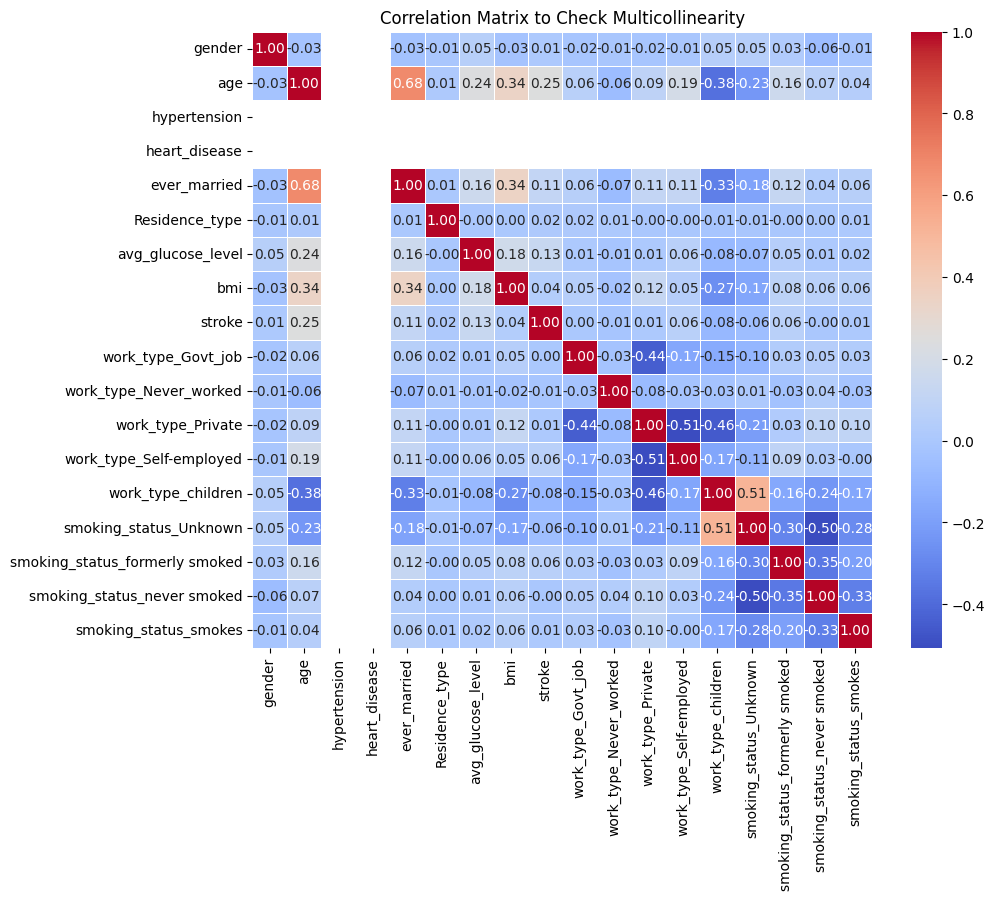

In [70]:
corr_matrix = df.corr()

# Display the correlation matrix
print(corr_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix to Check Multicollinearity")
plt.show()

#### From above we can see that there are no features which are having high correlation value, therefor I can conclude that there is no multicollinearity problem.

In [71]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_with_const = add_constant(df)

# Calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = df_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]
print(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



                           Feature       VIF
0                            const  0.000000
1                           gender  1.010558
2                              age  2.183419
3                     hypertension       NaN
4                    heart_disease       NaN
5                     ever_married  1.941509
6                   Residence_type  1.000956
7                avg_glucose_level  1.086368
8                              bmi  1.206086
9                           stroke  1.081013
10              work_type_Govt_job       inf
11          work_type_Never_worked       inf
12               work_type_Private       inf
13         work_type_Self-employed       inf
14              work_type_children       inf
15          smoking_status_Unknown       inf
16  smoking_status_formerly smoked       inf
17     smoking_status_never smoked       inf
18           smoking_status_smokes       inf


None of my features have very high VIF value

In [72]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0.0,0.0,1.0,1.0,228.69,36.60000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,61.0,0.0,0.0,1.0,0.0,202.21,28.85636,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [73]:
# Check correlation matrix to identify highly correlated features
corr_matrix = df.corr()

# Find pairs of features with correlation close to 1 or -1
highly_corr_features = corr_matrix[(corr_matrix > 0.95) & (corr_matrix < 1.0)].stack().index.tolist()
print("Highly correlated features:", highly_corr_features)

Highly correlated features: []


In [74]:
# Define features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

## Feature selection

In [75]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Fit a Random Forest model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Select top 5 important features
top_features = feature_importances.nlargest(5)
print("Top 5 features:", top_features)

Top 5 features: avg_glucose_level    0.298361
age                  0.262854
bmi                  0.250311
Residence_type       0.031936
gender               0.030330
dtype: float64


In [76]:
top_features

,0
avg_glucose_level,0.298361
age,0.262854
bmi,0.250311
Residence_type,0.031936
gender,0.030330


In [77]:
X.head(3)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0.0,0.0,1.0,1.0,228.69,36.60000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,61.0,0.0,0.0,1.0,0.0,202.21,28.85636,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,80.0,0.0,0.0,1.0,0.0,105.92,32.50000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [78]:
X = X[['age', 'gender', 'bmi', 'Residence_type']]

In [79]:
X.head()

,age,gender,bmi,Residence_type
0,67.0,1.0,36.60000,1.0
1,61.0,0.0,28.85636,0.0
2,80.0,1.0,32.50000,0.0
3,49.0,0.0,34.40000,1.0
4,79.0,0.0,24.00000,0.0


In [80]:
y.head()

,stroke
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


#Building a pipeline

In [81]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [83]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [84]:
numeric_cols=X.select_dtypes(include=np.number)
categorical_cols=X.select_dtypes(exclude=np.number)

In [85]:
# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols.columns),
        ('cat', categorical_transformer, categorical_cols.columns)
    ])

##Train Test Split  

In [86]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
y.value_counts()

,count
stroke,
0.0,4859
1.0,249


As our target column is imabalnce we are fixing this using SMOTE

In [89]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Original training set shape:", X_train.shape, "Class distribution:", y_train.value_counts())
print("Resampled training set shape:", X_train_resampled.shape, "Class distribution:", pd.Series(y_train_resampled).value_counts())

Original training set shape: (3575, 4) Class distribution: stroke
0.0    3415
1.0     160
Name: count, dtype: int64
Resampled training set shape: (6830, 4) Class distribution: stroke
0.0    3415
1.0    3415
Name: count, dtype: int64


In [90]:
X_train_resampled.shape

(6830, 4)

In [91]:
y_train_resampled.shape

(6830,)

In [92]:
X_train_resampled

,age,gender,bmi,Residence_type
0,33.000000,0.000000,26.300000,0.000000
1,30.000000,1.000000,23.900000,0.000000
2,37.000000,0.000000,26.600000,0.000000
3,12.000000,1.000000,23.700000,0.000000
4,44.000000,1.000000,29.400000,0.000000
...,...,...,...,...
6825,66.000000,0.000000,30.415623,0.305030
6826,35.091002,0.000000,29.362351,0.000000
6827,79.980570,1.000000,26.998057,1.000000
6828,68.611342,1.000000,29.510512,0.000000


In [93]:
print(X_train_resampled.shape)
print(X_test.shape)
print(y_train_resampled.shape)
print(y_test.shape)

(6830, 4)
(1533, 4)
(6830,)
(1533,)


## Model Imputation

In [94]:
#importing the classfication models and f1 score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

## KNN

In [95]:
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Train the KNN model
knn.fit(X_train_resampled,y_train_resampled)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_knn))
print(f"F1 Score (KNN): {f1_score(y_test, y_pred_knn, average='weighted')}")

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1444
         1.0       0.16      0.28      0.20        89

    accuracy                           0.87      1533
   macro avg       0.56      0.60      0.57      1533
weighted avg       0.91      0.87      0.89      1533

F1 Score (KNN): 0.8886807547967106


## Decision Tree

In [96]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the Decision Tree model
dt.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_dt = dt.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_dt))
print(f"F1 Score (Decision Tree): {f1_score(y_test, y_pred_dt, average='weighted')}")

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      1444
         1.0       0.11      0.12      0.12        89

    accuracy                           0.89      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.90      0.89      0.89      1533

F1 Score (Decision Tree): 0.8944073704490978


## Randomforest classifier

In [97]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)) # Added random_state for reproducibility
])

# Train the Random Forest model
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))
print(f"F1 Score (Random Forest): {f1_score(y_test, y_pred_rf, average='weighted')}")

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1444
         1.0       0.12      0.07      0.09        89

    accuracy                           0.92      1533
   macro avg       0.53      0.52      0.52      1533
weighted avg       0.90      0.92      0.91      1533

F1 Score (Random Forest): 0.9053427041885218


## Gradient Boosting

In [98]:
gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the Gradient Boosting model
gb.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_gb))
print(f"F1 Score (Gradient Boosting): {f1_score(y_test, y_pred_gb, average='weighted')}")

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1444
         1.0       0.20      0.28      0.24        89

    accuracy                           0.89      1533
   macro avg       0.58      0.61      0.59      1533
weighted avg       0.91      0.89      0.90      1533

F1 Score (Gradient Boosting): 0.9025828927193242


In [99]:
from sklearn.metrics import accuracy_score, f1_score
data = {
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ]
}
accuracy_scores = pd.DataFrame(data)
accuracy_scores_sorted = accuracy_scores.sort_values(ascending=False, by='Accuracy')
print(accuracy_scores_sorted)

               Model  Accuracy
2      Random Forest  0.915851
3  Gradient Boosting  0.894977
1      Decision Tree  0.891716
0                KNN  0.872798


## Hyperparameter Tuning

In [100]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.4 MB/s eta 0:00:00


## Implementation of Optuna for hyperparameter tuning

In [101]:
import optuna
def objective(trial):
    # Suggest the model to use
    model_type = trial.suggest_categorical('model', ['DecisionTree', 'RandomForest', 'GradientBoosting'])

    if model_type == 'DecisionTree':
        # Decision Tree parameters
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=0
        )

    elif model_type == 'RandomForest':
        # Random Forest parameters
        n_estimators = trial.suggest_int('n_estimators', 100, 1000,10)
        max_depth = trial.suggest_int('max_depth', 3, 20,2)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=0
        )

    else:  # Gradient Boosting
        # Gradient Boosting parameters
        n_estimators = trial.suggest_int('n_estimators', 100, 1000,20)
        max_depth = trial.suggest_int('max_depth', 3, 10,2)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=0
        )

    # Create pipeline with preprocessor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate F1 Score (weighted for class imbalance)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

In [102]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-03-27 12:28:44,311] A new study created in memory with name: no-name-fd7ef8bf-123f-4c96-885f-47e60a317b66
<ipython-input-101-3b582b687b75>:36: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-101-3b582b687b75>:37: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning:

The distribution is specified by [3, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 9].

[I 2025-03-27 12:28:48,685] Trial 0 finished with value: 0.9085832090986659 and parameters: {'model': 'GradientBoosting', 'n_estimators': 460, 'max_depth': 7, 'learning_rate': 0.23321729563864077, 'subsample': 0.7224461655639687}. Best is trial 0 with value: 0.9085832090986659.
<ipython-input-101-3b582b687b75>:36: FutureWarning:

suggest_int() got {'

In [103]:
# Best trial
print("Best trial:")
print(f"  Value: {study.best_value}")
print(f"  Params: {study.best_params}")

Best trial:
  Value: 0.9213005042307775
  Params: {'model': 'GradientBoosting', 'n_estimators': 520, 'max_depth': 3, 'learning_rate': 0.07675964879488457, 'subsample': 0.7823199409558916}


In [104]:
best_params = {'model': 'GradientBoosting', 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.027252583876413192, 'subsample': 0.8939945976863369}

In [105]:
from sklearn.metrics import f1_score, classification_report

# Determine the model type
model_type = best_params['model']

# Initialize the model based on the best parameters
if model_type == 'DecisionTree':
    model = DecisionTreeClassifier(**{k: v for k, v in best_params.items() if k != 'model'}, random_state=0)
elif model_type == 'RandomForest':
    model = RandomForestClassifier(**{k: v for k, v in best_params.items() if k != 'model'}, random_state=0)
else:
    model = GradientBoostingClassifier(**{k: v for k, v in best_params.items() if k != 'model'}, random_state=0)

# Create the best pipeline
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Fit the best pipeline using the training data
best_pipeline.fit(X_train, y_train)

# Make predictions using the fitted pipeline
y_pred_best = best_pipeline.predict(X_test)

# Calculate and print the weighted F1 score
weighted_f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f'Weighted F1 Score: {weighted_f1}')

# Print the classification report for precision, recall, and F1-score
class_report = classification_report(y_test, y_pred_best)
print(f'Classification Report:\n{class_report}')


Weighted F1 Score: 0.9209635446563554
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1444
         1.0       0.55      0.07      0.12        89

    accuracy                           0.94      1533
   macro avg       0.75      0.53      0.55      1533
weighted avg       0.92      0.94      0.92      1533



## Saving the trained model

In [106]:
import pickle

In [107]:
filename = "stroke_prediction_model.sav"

In [108]:
pickle.dump(best_pipeline, open(filename, "wb"))

In [109]:
loaded_model = pickle.load(open("stroke_prediction_model.sav", "rb"))

In [123]:
# Define feature names (ensure these match what the model was trained on)
feature_names = ["age", "gender", "bmi", "Residence_type"]  # Update with actual names

# Example feature values
new_data = (0.34, 0.45, 0.21, 0.11)

# Convert input into a DataFrame
new_data_df = pd.DataFrame([new_data], columns=feature_names)

# Make prediction
prediction = loaded_model.predict(new_data_df)

# Output the prediction
if prediction[0] == 1:
    print("The person is at risk of stroke.")
else:
    print("The person is not at risk of stroke.")


The person is not at risk of stroke.
